In [21]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Input, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.wdl_limited.camera.ops import py_camera_model_ops
from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2

In [22]:
import os
os.environ['CURL_CA_BUNDLE'] = '/home/aaylen/Documents/Waymo-Challenge/cacert.pem'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/aaylen/Documents/Waymo-Challenge/token.json'

In [23]:
# Dataset path
DATASET_FOLDER = 'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0'
TRAIN_FILES = os.path.join(DATASET_FOLDER, '*.tfrecord-*')

# Hyperparameters
BATCH_SIZE = 8
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
TRAJECTORY_POINTS = 20  # 5 seconds at 4 Hz = 20 points
IMAGE_HEIGHT = 192  # Downsample for faster processing
IMAGE_WIDTH = 960  # Combined width of three cameras (320*3)
VAL_SPLIT = 0.2

# Front camera indices
FRONT_LEFT_CAMERA = 2
FRONT_CAMERA = 1
FRONT_RIGHT_CAMERA = 3

In [24]:
def return_front3_cameras(data):
    """Return the front_left, front, and front_right cameras as a list of images and calibrations"""
    image_list = []
    calibration_list = []
    pose_list = []
    
    # Order: front_left, front, front_right
    camera_order = [FRONT_LEFT_CAMERA, FRONT_CAMERA, FRONT_RIGHT_CAMERA]
    
    for camera_name in camera_order:
        for index, image_content in enumerate(data.frame.images):
            if image_content.name == camera_name:
                # Decode the raw image string and convert to numpy type
                calibration = data.frame.context.camera_calibrations[index]
                image = tf.io.decode_image(image_content.image).numpy()
                image_list.append(image)
                calibration_list.append(calibration)
                pose_list.append(image_content.pose)
                break
    
    return image_list, calibration_list, pose_list

In [25]:
def parse_tfrecord(record):
    """Parse a TFRecord into features and labels."""
    data = wod_e2ed_pb2.E2EDFrame()
    data.ParseFromString(record.numpy())
    
    # Get the three front cameras
    try:
        front_images, _, _ = return_front3_cameras(data)
        if len(front_images) != 3:
            return None, None
        
        # Resize individual images before concatenation
        resized_images = [cv2.resize(img, (IMAGE_WIDTH // 3, IMAGE_HEIGHT)) for img in front_images]
        
        # Concatenate the three front camera images horizontally
        combined_image = np.concatenate(resized_images, axis=1)
        combined_image = combined_image / 255.0  # Normalize
        
        # Extract future waypoints (5 seconds at 4Hz = 20 points)
        future_waypoints = np.stack([
            data.future_states.pos_x[:TRAJECTORY_POINTS], 
            data.future_states.pos_y[:TRAJECTORY_POINTS], 
            data.future_states.pos_z[:TRAJECTORY_POINTS]
        ], axis=1)
        
        return combined_image, future_waypoints
    except Exception as e:
        print(f"Error processing record: {e}")
        return None, None

In [26]:
def load_dataset():
    """Load and prepare the dataset."""
    print("Loading dataset...")
    
    # Find all TFRecord files
    filenames = tf.io.matching_files(TRAIN_FILES)
    print(f"Found {len(filenames)} files")
    
    # Create dataset
    dataset = tf.data.TFRecordDataset(filenames, compression_type='')
    
    # Load data into memory
    images = []
    waypoints = []
    
    for i, record in enumerate(dataset):
        if i % 50 == 0:
            print(f"Processing record {i}")
        if i >= 2000:  # Limit to 2000 frames as requested
            break
            
        image, waypoint = parse_tfrecord(record)
        if image is not None and waypoint is not None:
            images.append(image)
            waypoints.append(waypoint)
    
    print(f"Loaded {len(images)} valid samples")
    return np.array(images), np.array(waypoints)

In [ ]:
def build_model():
    """Build ResNet-based trajectory prediction model."""
    # Combined image input
    image_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    
    # ResNet backbone with pretrained weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
    
    # Freeze some layers of ResNetimages, waypoints = load_dataset()
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Add trajectory prediction head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    
    # Output layer: 3D coordinates for each trajectory point (20 points * 3 coordinates)
    trajectory_output = Dense(TRAJECTORY_POINTS * 3, activation='linear')(x)
    
    # Create model
    model = Model(inputs=image_input, outputs=trajectory_output)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [28]:
def project_vehicle_to_image(vehicle_pose, calibration, points):
    """Projects from vehicle coordinate system to image with global shutter."""
    # Transform points from vehicle to world coordinate system
    pose_matrix = np.array(vehicle_pose.transform).reshape(4, 4)
    world_points = np.zeros_like(points)
    for i, point in enumerate(points):
        cx, cy, cz, _ = np.matmul(pose_matrix, [*point, 1])
        world_points[i] = (cx, cy, cz)

    # Populate camera image metadata
    extrinsic = tf.reshape(
        tf.constant(list(calibration.extrinsic.transform), dtype=tf.float32),
        [4, 4])
    intrinsic = tf.constant(list(calibration.intrinsic), dtype=tf.float32)
    metadata = tf.constant([
        calibration.width,
        calibration.height,
        open_dataset.CameraCalibration.GLOBAL_SHUTTER,
    ], dtype=tf.int32)
    camera_image_metadata = list(vehicle_pose.transform) + [0.0] * 10

    # Perform projection and return projected image coordinates (u, v, ok)
    return py_camera_model_ops.world_to_image(extrinsic, intrinsic, metadata,
                                        camera_image_metadata,
                                        world_points).numpy()

In [29]:
def draw_points_on_image(image, points, color, size=5):
    """Draws points on an image with specified color."""
    img_copy = image.copy()
    for point in points:
        if point[2]:  # Check if the point is valid (ok flag is True)
            cv2.circle(img_copy, (int(point[0]), int(point[1])), size, color, -1)
    return img_copy


In [30]:
def visualize_predictions(model, test_images, test_waypoints, dataset):
    """Visualize model predictions alongside ground truth."""
    # Make predictions
    predictions = model.predict(test_images)
    predictions = predictions.reshape(-1, TRAJECTORY_POINTS, 3)
    
    # Get a few test samples
    dataset_iter = dataset.as_numpy_iterator()
    
    plt.figure(figsize=(20, 20))
    
    for i in range(min(5, len(test_images))):
        try:
            # Get a sample from the dataset
            bytes_example = next(dataset_iter)
            data = wod_e2ed_pb2.E2EDFrame()
            data.ParseFromString(bytes_example)
            
            # Get front three cameras
            front_images, front_calibrations, front_poses = return_front3_cameras(data)
            
            if len(front_images) != 3:
                continue
            
            # Project ground truth and predictions to each camera and visualize
            concatenated_gt_image = None
            
            for j, (image, calibration, pose) in enumerate(zip(front_images, front_calibrations, front_poses)):
                # Get ground truth and prediction for this sample
                ground_truth = test_waypoints[i]
                predicted = predictions[i]
                
                # Project to camera space
                gt_camera_space = project_vehicle_to_image(pose, calibration, ground_truth)
                pred_camera_space = project_vehicle_to_image(pose, calibration, predicted)
                
                # Draw points
                image_with_gt = draw_points_on_image(image, gt_camera_space, color=(0, 255, 0), size=7)  # Green for ground truth
                image_with_both = draw_points_on_image(image_with_gt, pred_camera_space, color=(255, 0, 0), size=5)  # Red for predictions
                
                # First image or concatenate
                if concatenated_gt_image is None:
                    concatenated_gt_image = image_with_both
                else:
                    concatenated_gt_image = np.concatenate([concatenated_gt_image, image_with_both], axis=1)
            
            plt.subplot(5, 1, i+1)
            plt.imshow(concatenated_gt_image)
            plt.title(f"Sample {i+1}: Green = Ground Truth, Red = Prediction")
            
        except StopIteration:
            break
    
    plt.tight_layout()
    plt.savefig('predictions_visualization.png')
    plt.show()

In [31]:
# Load the dataset
images, waypoints = load_dataset()

Loading dataset...
Found 315 files


2025-04-09 11:16:24.927597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [315]
	 [[{{node Placeholder/_0}}]]


Processing record 0
Processing record 50
Processing record 100
Processing record 150
Processing record 200
Processing record 250
Processing record 300
Processing record 350
Processing record 400
Processing record 450
Processing record 500
Processing record 550
Processing record 600
Processing record 650
Processing record 700
Processing record 750
Processing record 800
Processing record 850
Processing record 900
Processing record 950
Processing record 1000
Processing record 1050
Processing record 1100
Processing record 1150
Processing record 1200
Processing record 1250
Processing record 1300
Processing record 1350
Processing record 1400
Processing record 1450
Processing record 1500
Processing record 1550
Processing record 1600
Processing record 1650
Processing record 1700
Processing record 1750
Processing record 1800
Processing record 1850
Processing record 1900
Processing record 1950
Processing record 2000
Loaded 2000 valid samples


In [32]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images, waypoints.reshape(waypoints.shape[0], -1),
    test_size=VAL_SPLIT, random_state=42
)
print(f"Training on {X_train.shape[0]} samples, validating on {X_val.shape[0]} samples")


Training on 1600 samples, validating on 400 samples


In [33]:
# Build model
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 960, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 966, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 480, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 96, 480, 64)  256         ['conv1_conv[0][0]']         

In [34]:
# Callbacks
checkpoint = ModelCheckpoint(
    'waymo_e2e_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [35]:
# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 91.6643 - mae: 4.0964
Epoch 1: val_loss improved from inf to 262.14099, saving model to waymo_e2e_model.h5
200/200 [==============================] - 238s 1s/step - loss: 91.6643 - mae: 4.0964 - val_loss: 262.1410 - val_mae: 8.0036
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 76.2209 - mae: 3.7441
Epoch 2: val_loss improved from 262.14099 to 144.95834, saving model to waymo_e2e_model.h5
200/200 [==============================] - 237s 1s/step - loss: 76.2209 - mae: 3.7441 - val_loss: 144.9583 - val_mae: 5.7696
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 68.8815 - mae: 3.5874
Epoch 3: val_loss improved from 144.95834 to 116.24919, saving model to waymo_e2e_model.h5
200/200 [==============================] - 235s 1s/step - loss: 68.8815 - mae: 3.5874 - val_loss: 116.2492 - val_mae: 5.0742
Epoch 4/10
200/200 [==============================] - ETA: 0s - loss: 68.5477 - ma

In [36]:
# Create TF dataset for original data format to access calibration info
filenames = tf.io.matching_files(TRAIN_FILES)
dataset = tf.data.TFRecordDataset(filenames, compression_type='')


1/1 [==============================] - 1s 821ms/step


2025-04-09 12:03:10.974962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [315]
	 [[{{node Placeholder/_0}}]]


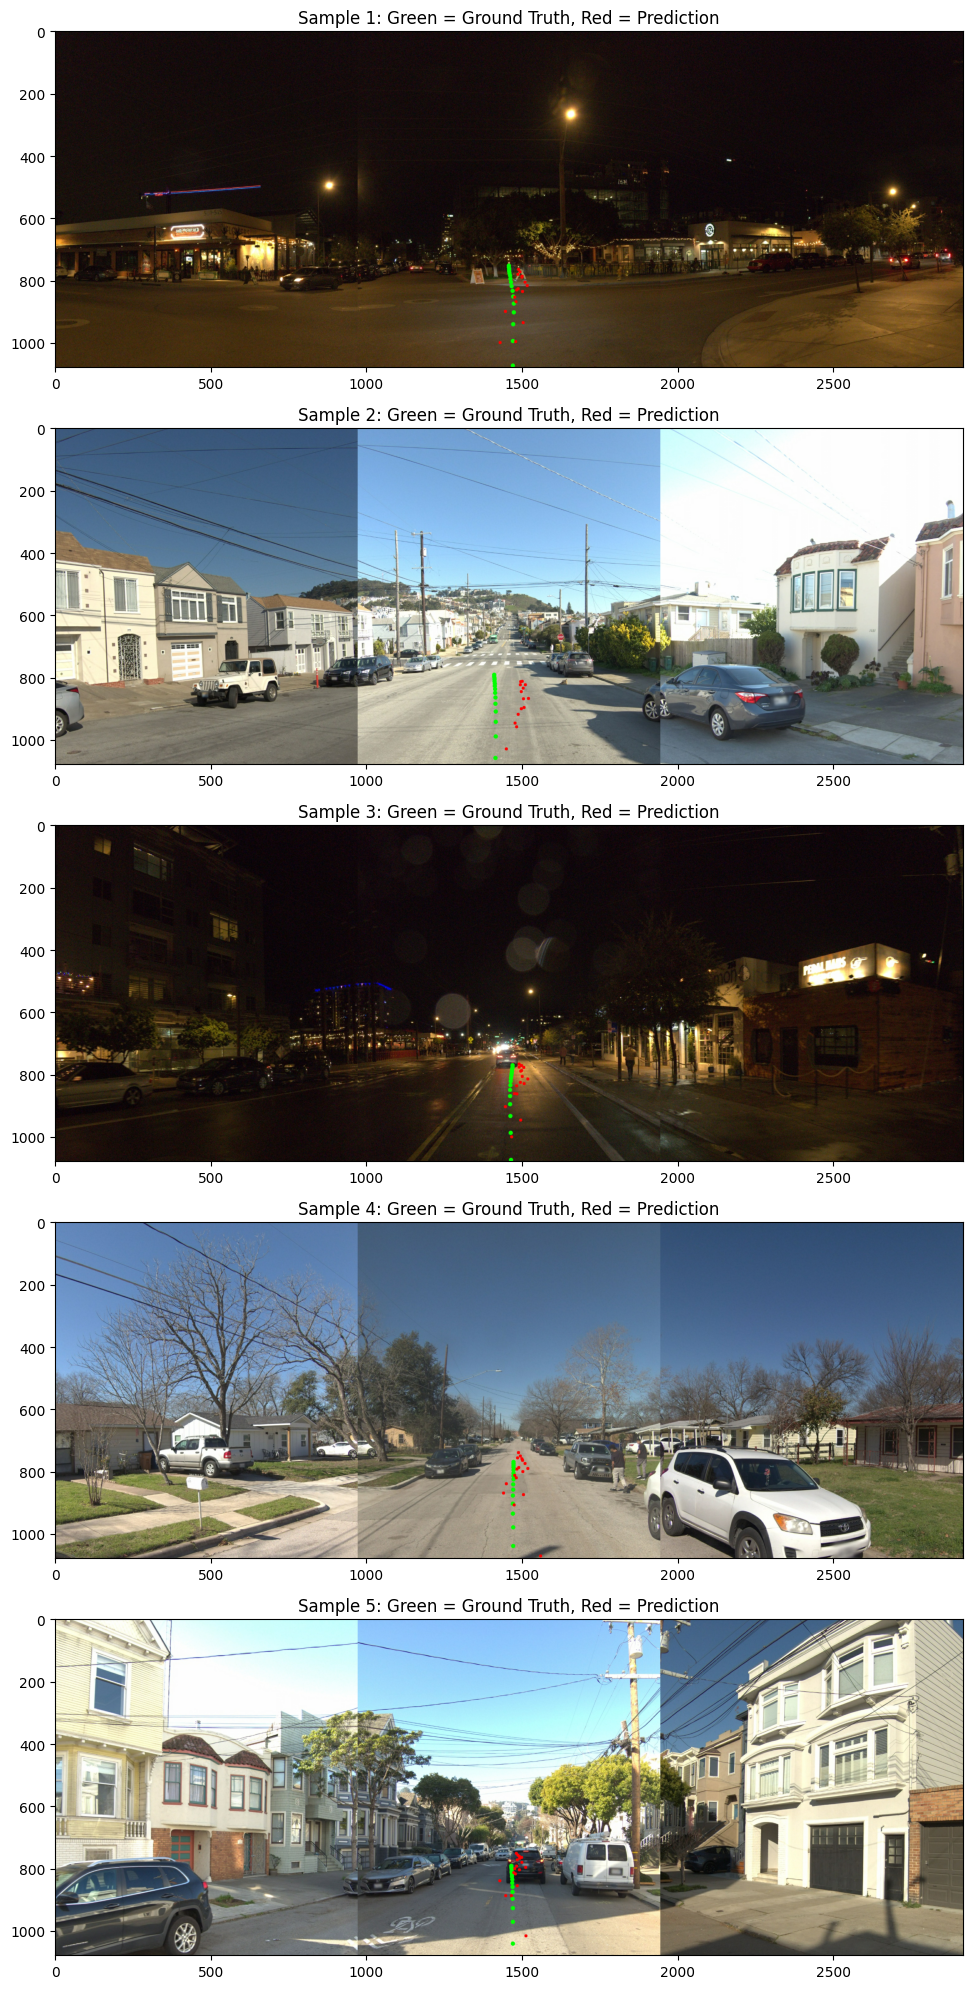

In [37]:
# Visualize predictions
visualize_predictions(model, X_val[:5], y_val[:5].reshape(-1, TRAJECTORY_POINTS, 3), dataset)


In [62]:
# Save the model for later use
model.save('waymo_e2e_driving_model.h5')
print("Model saved to waymo_e2e_driving_model.h5")

Model saved to waymo_e2e_driving_model.h5


2025-04-09 12:10:39.918547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [315]
	 [[{{node Placeholder/_0}}]]


Future waypoints shape: (20, 3)
First few waypoints: [[ 2.15240479e+00 -5.12695312e-03  5.94329834e-03]
 [ 4.28076172e+00 -9.88769531e-03  1.33132935e-02]
 [ 6.38391113e+00 -1.47705078e-02  2.29492188e-02]]
1/1 [==============================] - 0s 99ms/step


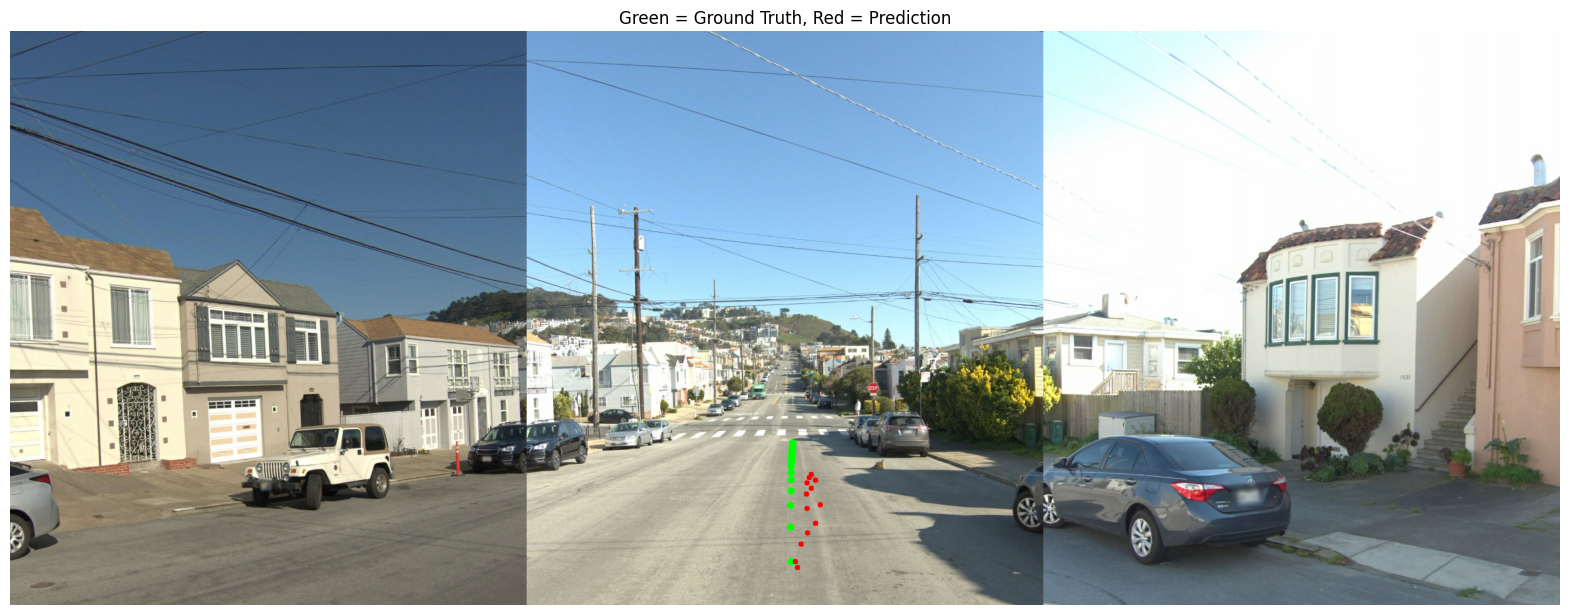

Mean Absolute Error for this example: 3.4628


In [61]:
# # Test a Single Example

# Get a specific example from the dataset by skipping to the desired index
desired_index = 1  # Change this to the index of the sample you want
example_iter = dataset.skip(desired_index).as_numpy_iterator()
bytes_example = next(example_iter)
data = wod_e2ed_pb2.E2EDFrame()
data.ParseFromString(bytes_example)

# Extract the front cameras, calibrations, and poses
front_images, front_calibrations, front_poses = return_front3_cameras(data)

# Extract the future waypoints
future_waypoints = np.stack([
    data.future_states.pos_x[:TRAJECTORY_POINTS], 
    data.future_states.pos_y[:TRAJECTORY_POINTS], 
    data.future_states.pos_z[:TRAJECTORY_POINTS]
], axis=1)

print(f"Future waypoints shape: {future_waypoints.shape}")
print(f"First few waypoints: {future_waypoints[:3]}")

# Process the image for model input
combined_image = np.concatenate([cv2.resize(img, (IMAGE_WIDTH // 3, IMAGE_HEIGHT)) for img in front_images], axis=1)
normalized_image = combined_image / 255.0
input_image = np.expand_dims(normalized_image, axis=0)  # Add batch dimension

# Get model prediction
predicted_waypoints = model.predict(input_image)
predicted_waypoints = predicted_waypoints.reshape(TRAJECTORY_POINTS, 3)

# Visualize the prediction alongside ground truth
plt.figure(figsize=(20, 10))

# Create visualization with ground truth and prediction for each camera
concatenated_result = None

for i, (image, calibration, pose) in enumerate(zip(front_images, front_calibrations, front_poses)):
    # Project ground truth and prediction to camera space
    gt_camera_space = project_vehicle_to_image(pose, calibration, future_waypoints)
    pred_camera_space = project_vehicle_to_image(pose, calibration, predicted_waypoints)
    
    # Draw points
    image_with_gt = draw_points_on_image(image, gt_camera_space, color=(0, 255, 0), size=7)  # Green for ground truth
    image_with_both = draw_points_on_image(image_with_gt, pred_camera_space, color=(255, 0, 0), size=5)  # Red for predictions
    
    # First image or concatenate
    if concatenated_result is None:
        concatenated_result = image_with_both
    else:
        concatenated_result = np.concatenate([concatenated_result, image_with_both], axis=1)

plt.imshow(concatenated_result)
plt.title("Green = Ground Truth, Red = Prediction")
plt.axis('off')
plt.show()

# Calculate Mean Absolute Error for this example
mae = np.mean(np.abs(predicted_waypoints - future_waypoints))
print(f"Mean Absolute Error for this example: {mae:.4f}")